# Sentiment Analysis on a Federal Docket: Heat Injury and Illness Prevention in Outdoor and Indoor Work Settings

<b>Definitions</b><br>
- A docket is a collection of documents/text/information related to a rulemaking or regulatory action
- Regulation.gov is a centralized and public repository for these dockets. This enables transparency, and enables the public to get updated on regulatory actions
- Dockets will include a calendar of dates of the different proceedings


<b>Docket Summary:</b>

OSHA is proposing to issue a new standard, titled Heat Injury and Illness Prevention in Outdoor and Indoor Work Settings. The standard would apply to all employers conducting outdoor and indoor work in all general industry, construction, maritime, and agriculture sectors where OSHA has jurisdiction, with some exceptions. It would be a programmatic standard that would require employers to create a plan to evaluate and control heat hazards in their workplace. It would more clearly set forth employer obligations and the measures necessary to effectively protect employees from hazardous heat. OSHA requests comments on all aspects of the proposed rule.

<b>AI-guided experimental summarization and sentiment
analysis of Dockets:</b> https://www.fda.gov/media/171124/download

<b>Summary of exercise:</b>

- Select a recent, high-impact federal regulation docket from regulations.gov.
- Extract relevant data from the docket, including the proposed regulation and associated
public comments. (Note: You may select a subset of the data for analysis.)
- Perform exploratory data analysis (EDA) to explore and display key characteristics of the
textual data.
- Identify themes and extract insights from the documents.
- Apply sentiment analysis techniques to assess the public comments. Consider how
bot-generated inputs might differ from human comments.


<b>Deliverables:</b>

1. Develop a Python script that performs a comprehensive analysis of the data. You may use
either a Jupyter notebook or a standalone .py script for the implementation.
- a. Along with the source code, include a README.md file in Markdown format which
documents your solution and how to use it. Deliver the application via shared git
repository (e.g. GitHub, BitBucket).
2. Given the above, present your findings in a concise format to business stakeholders (you
can use a short summary document or a few presentation slides).
- a. Be prepared to talk about your decision-making at a high level, for tech stack,
model selection, and implementation.

# 1. Data Extraction

## Web Parsing

Using the US Gov's API key, we can the docket info from the website as well as the comments:

<b>Web Parsing Comment Data</b>

In [ ]:
from comments_downloader import CommentsDownloader
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed") 

api_key = 'BgYDvERglnMGIokigbAPUZW7KslCI1gMWa5OjEsp'
downloader = CommentsDownloader(api_key)
docket_id = 'OSHA-2021-0009-4761' 
downloader.gather_comments_by_docket(docket_id=docket_id, db_filename="testdb.db", csv_filename=r'c:\Users\U355394\Desktop\doc_comments.csv')

<b>Extracting the document information: We save the document metadata, then save the text, then export to json since excel has a size limit in each cell</b>

In [ ]:
import os
from PyPDF2 import PdfReader
import requests
import json
# Replace with your actual API key
api_key = '3XTFLQVT6HgkeGm1zhfQbmf28x8x1CSBsmio1t2v'

# Base URL for the API
base_url = 'https://api.regulations.gov/v4'

# Function to get document metadata
def get_document_metadata(document_id):
    url = f'{base_url}/documents/{document_id}'
    headers = {'X-Api-Key': api_key}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error: {response.status_code} - {response.text}')
        return None

# Function to download a file
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f'File downloaded: {save_path}')
    else:
        print(f'Error: {response.status_code} - {response.text}')

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ""
    try:
        pdf_reader = PdfReader(file_path)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    except Exception as e:
        print(f"Error reading PDF file {file_path}: {e}")
    return text

# Main function to process a document
def process_document(document_id, save_folder):
    metadata = get_document_metadata(document_id)
    if metadata:
        # Ensure 'fileFormats' exists in the metadata
        if 'fileFormats' in metadata['data']['attributes']:
            file_formats = metadata['data']['attributes']['fileFormats']
            documents = []
            for file_format in file_formats:
                file_url = file_format['fileUrl']
                file_name = os.path.basename(file_url)
                save_path = os.path.join(save_folder, file_name)
                
                # Download the file
                download_file(file_url, save_path)
                
                # Extract text from the file
                text = ""
                if file_name.endswith(".pdf"):
                    text = extract_text_from_pdf(save_path)
                
                # Prepare document data
                document_data = {
                    "document_id": document_id,
                    "file_name": file_name,
                    "text": text,
                    "metadata": metadata['data']['attributes']  # Include all attributes dynamically
                }
                documents.append(document_data)
            
            # Save all documents to a JSON file
            json_filename = os.path.join(save_folder, f"{document_id}.json")
            with open(json_filename, 'w', encoding='utf-8') as json_file:
                json.dump(documents, json_file, ensure_ascii=False, indent=4)
            print(f"Data saved to '{json_filename}'")
        else:
            print('No file formats available for this document.')
    else:
        print('Failed to retrieve metadata.')

# Example Usage
save_folder = "./Document_Data"
document_ids = [
    "OSHA-2021-0009-0001",
    "OSHA-2021-0009-0178",
    "OSHA-2021-0009-1059",
    "OSHA-2021-0009-3949",
    "OSHA-2021-0009-4761"
]

for doc_id in document_ids:
    process_document(doc_id, save_folder)


## Importing Data

<b>Importing Document Data and creating the corpus</b>

In [1661]:
import pandas as pd
def process_json_file(file_path):
    """
    Process a single JSON file and return a pandas DataFrame with relevant data.
    """
    with open(file_path, 'r', encoding='utf-8') as json_file:
        # Load JSON data
        data = json.load(json_file)
        
        # Convert JSON data to a DataFrame
        df = pd.DataFrame(data)
        
        # Normalize metadata if it exists
        if 'metadata' in df.columns:
            metadata_df = pd.json_normalize(df['metadata'])
            
            # Concatenate metadata with the original DataFrame
            df = pd.concat([df.drop(columns=['metadata']), metadata_df], axis=1)
        
        # Rename columns as per the requirements
        column_renames = {
            "document_id": "Document_ID",
            "docAbstract": "Abstract",
            "commentStartDate": "Comment_Start_Date",
            "commentEndDate": "Comment_End_Date",
            "documentType": "Document_Type",
            "docketId": "Docket_ID",
            "postedDate": "Posted_Date",
            "text": "Text",
            'title': 'Title'
        }
        df.rename(columns=column_renames, inplace=True)
    
    return df

def process_all_json_files(folder_path):
    """
    Process all JSON files in a folder and concatenate them into a single DataFrame.
    """
    dataframes = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            # Process only JSON files
            file_path = os.path.join(folder_path, file_name)
            
            # Process each JSON file and append the resulting DataFrame
            df = process_json_file(file_path)
            dataframes.append(df)
    
    # Concatenate all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df

# Define the folder containing the JSON files
folder_path = r'C:\Users\U355394\Desktop\Personal Projects\Document_Data'

# Process all JSON files and combine into a single DataFrame
combined_df = process_all_json_files(folder_path)

df_docs = combined_df.loc[:,['Document_ID', 'Docket_ID', 'Abstract', 'Document_Type', 'Title', 'Text', 'Comment_Start_Date', 'Comment_End_Date', 'Posted_Date']]
df_docs = df_docs.drop_duplicates(subset=['Document_ID']).reset_index(drop=True)
df_docs.head()

Document_ID       Docket_ID  \
0  OSHA-2021-0009-0001  OSHA-2021-0009   
1  OSHA-2021-0009-0178  OSHA-2021-0009   
2  OSHA-2021-0009-1059  OSHA-2021-0009   
3  OSHA-2021-0009-3949  OSHA-2021-0009   
4  OSHA-2021-0009-4761  OSHA-2021-0009   

                                            Abstract  Document_Type  \
0  Federal Register of October 27, 2021 (86 FR 59...  Proposed Rule   
1  Federal Register of December 3, 2021. (86 FR 6...  Proposed Rule   
2  The purpose of this memorandum is to notify in...          Other   
3  The purpose of this memorandum is to allow for...          Other   
4  Federal Register of August 30, 20204. (89 FR 7...  Proposed Rule   

                                               Title  \
0  Heat Injury and Illness Prevention in Outdoor ...   
1  Heat Injury and Illness Prevention in Outdoor ...   
2  Memorandum Reopening the Comment Period on Hea...   
3  Memorandum Allowing OSHA’s Supporting and Rela...   
4  Heat Injury and Illness Prevention in Outdoor ...   

                                                Text    Comment_Start_Date  \
0  59309 Federal Register / Vol. 86, No. 205 / We...  2021-10-27T04:00:00Z   
1  68594 Federal Register / Vol. 86, No. 230 / Fr...  2021-12-03T05:00:00Z   
2  August 21, 2023 \nM\nEMORANDUM  FOR:  The Gene...  2023-08-22T04:00:00Z   
3  Occupational Safety and Health Administration ...  2024-08-09T04:00:00Z   
4  70698 Federal Register / Vol. 89, No. 169 / Fr...  2024-08-30T04:00:00Z   

       Comment_End_Date           Posted_Date  
0  2022-01-27T04:59:59Z  2021-10-27T04:00:00Z  
1  2022-01-27T04:59:59Z  2021-12-03T05:00:00Z  
2  2023-12-24T04:59:59Z  2023-08-22T04:00:00Z  
3                  None  2024-08-09T04:00:00Z  
4  2024-12-31T04:59:59Z  2024-08-30T04:00:00Z

In [1662]:
corpus = " ".join(df_docs['Text'].astype(str))
df_docs.loc[0, 'Corpus'] = corpus
df_docs['Corpus'] = df_docs['Corpus'].fillna('')
df_docs

Document_ID       Docket_ID  \
0  OSHA-2021-0009-0001  OSHA-2021-0009   
1  OSHA-2021-0009-0178  OSHA-2021-0009   
2  OSHA-2021-0009-1059  OSHA-2021-0009   
3  OSHA-2021-0009-3949  OSHA-2021-0009   
4  OSHA-2021-0009-4761  OSHA-2021-0009   

                                            Abstract  Document_Type  \
0  Federal Register of October 27, 2021 (86 FR 59...  Proposed Rule   
1  Federal Register of December 3, 2021. (86 FR 6...  Proposed Rule   
2  The purpose of this memorandum is to notify in...          Other   
3  The purpose of this memorandum is to allow for...          Other   
4  Federal Register of August 30, 20204. (89 FR 7...  Proposed Rule   

                                               Title  \
0  Heat Injury and Illness Prevention in Outdoor ...   
1  Heat Injury and Illness Prevention in Outdoor ...   
2  Memorandum Reopening the Comment Period on Hea...   
3  Memorandum Allowing OSHA’s Supporting and Rela...   
4  Heat Injury and Illness Prevention in Outdoor ...   

                                                Text    Comment_Start_Date  \
0  59309 Federal Register / Vol. 86, No. 205 / We...  2021-10-27T04:00:00Z   
1  68594 Federal Register / Vol. 86, No. 230 / Fr...  2021-12-03T05:00:00Z   
2  August 21, 2023 \nM\nEMORANDUM  FOR:  The Gene...  2023-08-22T04:00:00Z   
3  Occupational Safety and Health Administration ...  2024-08-09T04:00:00Z   
4  70698 Federal Register / Vol. 89, No. 169 / Fr...  2024-08-30T04:00:00Z   

       Comment_End_Date           Posted_Date  \
0  2022-01-27T04:59:59Z  2021-10-27T04:00:00Z   
1  2022-01-27T04:59:59Z  2021-12-03T05:00:00Z   
2  2023-12-24T04:59:59Z  2023-08-22T04:00:00Z   
3                  None  2024-08-09T04:00:00Z   
4  2024-12-31T04:59:59Z  2024-08-30T04:00:00Z   

                                              Corpus  
0  59309 Federal Register / Vol. 86, No. 205 / We...  
1                                                     
2                                                     
3                                                     
4

<b>Importing Comment Data:</b>

In [1663]:

import pandas as pd
df_comments = pd.read_csv(r'c:\Users\U355394\Desktop\doc_comments.csv')

df_comments = df_comments.drop(columns=['Unnamed: 8'])
df_comments.head()

Comment_ID          Document_ID AgencyID                    City  \
0  OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA            Philadelphia   
1  OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA            Mount Vernon   
2  OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA  Rancho Santa Margarita   
3  OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA                New York   
4  OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA           New Braunfels   

                                             Comment       Docket_ID  \
0  Every worker deserves protection from extreme ...  OSHA-2021-0009   
1  I fully support the Occupational Safety and He...  OSHA-2021-0009   
2  Every worker deserves protection from extreme ...  OSHA-2021-0009   
3  I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4  I fully support the Occupational Safety and He...  OSHA-2021-0009   

        DocumentType       Time of Comment  
0  Public Submission  2024-10-09T20:05:05Z  
1  Public Submission  2024-10-09T20:33:26Z  
2  Public Submission  2024-10-09T20:10:40Z  
3  Public Submission  2024-09-26T16:23:32Z  
4  Public Submission  2024-10-09T20:28:53Z

<b>importing docket metadata</b>

In [1664]:
file_path = r'C:\Users\U355394\Desktop\Personal Projects\OSHA-2021-0009_info.json'
with open(file_path, 'r', encoding='utf-8') as json_file:
    # Load JSON data
    data = json.load(json_file)
    
    # Convert JSON data to a DataFrame
    df = pd.DataFrame(data)
    
    # Normalize metadata if it exists
    if 'metadata' in df.columns:
        metadata_df = pd.json_normalize(df['data'])
        
        # Concatenate metadata with the original DataFrame
        df = pd.concat([df.drop(columns=['metadata']), metadata_df], axis=1)
df

data  \
attributes  {'displayProperties': [{'name': 'shortTitle', ...   
id                                             OSHA-2021-0009   
links       {'self': 'https://api.regulations.gov/v4/docke...   
type                                                  dockets   

                          Abstract                               Abstract_Div  
attributes  Abstract not available  Failed to retrieve page. Status code: 403  
id          Abstract not available  Failed to retrieve page. Status code: 403  
links       Abstract not available  Failed to retrieve page. Status code: 403  
type        Abstract not available  Failed to retrieve page. Status code: 403

# 2. Data Pre-Processing

<b>Text Pre-Processing:</b> We remove the stop words, put comments in lower case, and Lemmatize data for Document and Comment Data

In [1665]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import wordnet

def preprocess_text_column(df, text_column):
    """
    Preprocesses a text column in a DataFrame by:
    - Removing specific patterns, HTML tags, signatures, and extra whitespace.
    - Removing stopwords, punctuation, special characters, hyperlinks, and hyphens.
    - Excluding isolated single characters.
    - Selecting only valid tokens (a-z).
    - Lemmatizing tokens.
    - Joining tokens back into a single string.
    """
    processed_column = f"Processed_{text_column}"

    # Initialize stopwords, punctuation, and lemmatizer
    stop_words = set(stopwords.words("english"))
    punctuation_list = list(punctuation)
    punctuation_list.extend(["@", "http", "https", "org", "doi"])

    # Add specific patterns
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        """Cleans text by removing unwanted patterns and noise."""
        # Remove URLs
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        
        # Remove specific patterns
        text = re.sub(r"\bet al\b", "", text, flags=re.IGNORECASE)
        text = re.sub(r"\bOSHA\b", "", text, flags=re.IGNORECASE)
        text = re.sub(r"(sincerely|thank you)[\s\S]*$", "", text, flags=re.IGNORECASE)
        
        # Remove HTML tags
        text = re.sub(r"<.*?>", " ", text)
        
        # Remove isolated single characters (e.g., 'j', 'x')
        text = re.sub(r"\b[a-zA-Z]\b", "", text)
        
        # Remove HTML entities, punctuation, and non-alphanumeric characters
        text = re.sub(r"&[a-z]+;", "", text)
        text = re.sub(r"[-/\.]", " ", text)
        text = re.sub(r"[^\w\s]", "", text)
        
        # Remove specific unwanted words like "org" and "doi"
        text = re.sub(r"\b(org|doi|http|https)\b", "", text)
        
        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()
        
        return text

    # Apply preprocessing
    for index, text in df[text_column].items():
        # Clean text
        cleaned_text = clean_text(text)
        
        # Tokenize and filter tokens
        tokens = word_tokenize(cleaned_text.lower())
        filtered_tokens = [
            lemmatizer.lemmatize(word, pos=wordnet.VERB)
            for word in tokens
            if word not in stop_words and word not in punctuation_list and re.match(r"^[a-z]+$", word)
        ]
        
        # Join tokens into a single string
        df.at[index, processed_column] = " ".join(filtered_tokens) if filtered_tokens else ""

    return df



# Apply the preprocessing function
df_comments = preprocess_text_column(df_comments, text_column="Comment")
df_docs = preprocess_text_column(df_docs, text_column="Corpus")
df_docs = preprocess_text_column(df_docs, text_column="Text")


In [1666]:
df_docs.Processed_Corpus.iloc[0]

'federal register vol wednesday october propose rule extension days sufficient preliminary stage therefore doe extend comment period november sign authority document department energy sign october kelly speak backman principal deputy assistant secretary act assistant secretary energy efficiency renewable energy pursuant delegate authority secretary energy document original signature date maintain doe administrative purpose compliance requirements office federal register undersign doe federal register liaison officer authorize sign submit document electronic format publication official document department energy administrative process way alter legal effect document upon publication federal register sign washington dc october treena garrett federal register liaison officer department energy fr doc file bill code department labor occupational safety health administration cfr part docket rin heat injury illness prevention outdoor indoor work settings agency occupational safety health admi

<b>Creating tokens</b>

In [1667]:
def clean(text):
    tokens = word_tokenize(text)   
    
    return tokens

df_comments["Tokens"] = df_comments["Processed_Comment"].apply(clean)
df_docs["Tokens"] = df_docs['Processed_Corpus']

<b>Adding Time Data</b>

In [1668]:
df_comments['Time of Comment'] = pd.to_datetime(df_comments['Time of Comment'], format='%Y-%m-%dT%H:%M:%SZ')

df_comments['Day_of_Week'] = df_comments['Time of Comment'].dt.day_name()
df_comments['Month'] = df_comments['Time of Comment'].dt.month_name()
df_comments['Year'] = df_comments['Time of Comment'].dt.year

df_comments

Comment_ID          Document_ID AgencyID  \
0      OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA   
1      OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA   
2      OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA   
3      OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA   
4      OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA   
...                     ...                  ...      ...   
12377   OSHA-2021-0009-3256  OSHA-2021-0009-1059      NaN   
12378   OSHA-2021-0009-2947  OSHA-2021-0009-1059      NaN   
12379   OSHA-2021-0009-1967  OSHA-2021-0009-1059      NaN   
12380   OSHA-2021-0009-3847  OSHA-2021-0009-1059      NaN   
12381   OSHA-2021-0009-3450  OSHA-2021-0009-1059      NaN   

                         City  \
0                Philadelphia   
1                Mount Vernon   
2      Rancho Santa Margarita   
3                    New York   
4               New Braunfels   
...                       ...   
12377                New York   
12378                 Chicago   
12379                Falmouth   
12380             Kansas City   
12381           New Braunfels   

                                                 Comment       Docket_ID  \
0      Every worker deserves protection from extreme ...  OSHA-2021-0009   
1      I fully support the Occupational Safety and He...  OSHA-2021-0009   
2      Every worker deserves protection from extreme ...  OSHA-2021-0009   
3      I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4      I fully support the Occupational Safety and He...  OSHA-2021-0009   
...                                                  ...             ...   
12377  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12378  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12379  James K. Hadcroft here. Please become part of ...  OSHA-2021-0009   
12380  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12381  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   

            DocumentType     Time of Comment  \
0      Public Submission 2024-10-09 20:05:05   
1      Public Submission 2024-10-09 20:33:26   
2      Public Submission 2024-10-09 20:10:40   
3      Public Submission 2024-09-26 16:23:32   
4      Public Submission 2024-10-09 20:28:53   
...                  ...                 ...   
12377                NaN 2024-01-09 05:00:00   
12378                NaN 2024-01-08 05:00:00   
12379                NaN 2023-12-22 05:00:00   
12380                NaN 2024-01-12 05:00:00   
12381                NaN 2024-01-10 05:00:00   

                                       Processed_Comment  \
0      every worker deserve protection extreme heat w...   
1      fully support occupational safety health admin...   
2      every worker deserve protection extreme heat w...   
3      write support propose rule protect non residen...   
4      fully support occupational safety health admin...   
...                                                  ...   
12377  urge swiftly issue strong preventative heat st...   
12378  urge swiftly issue strong preventative heat st...   
12379  jam hadcroft please become part solution urge ...   
12380  urge swiftly issue strong preventative heat st...   
12381  urge swiftly issue strong preventative heat st...   

                                                  Tokens Day_of_Week  \
0      [every, worker, deserve, protection, extreme, ...   Wednesday   
1      [fully, support, occupational, safety, health,...   Wednesday   
2      [every, worker, deserve, protection, extreme, ...   Wednesday   
3      [write, support, propose, rule, protect, non, ...    Thursday   
4      [fully, support, occupational, safety, health,...   Wednesday   
...                                                  ...         ...   
12377  [urge, swiftly, issue, strong, preventative, h...     Tuesday   
12378  [urge, swiftly, issue, strong, preventative, h...      Monday   
12379  [jam, hadcroft, pleas

# 3. Exploratory Data Analysis

<b>Example of Comments which become duplicates after pre-processing data:</b>

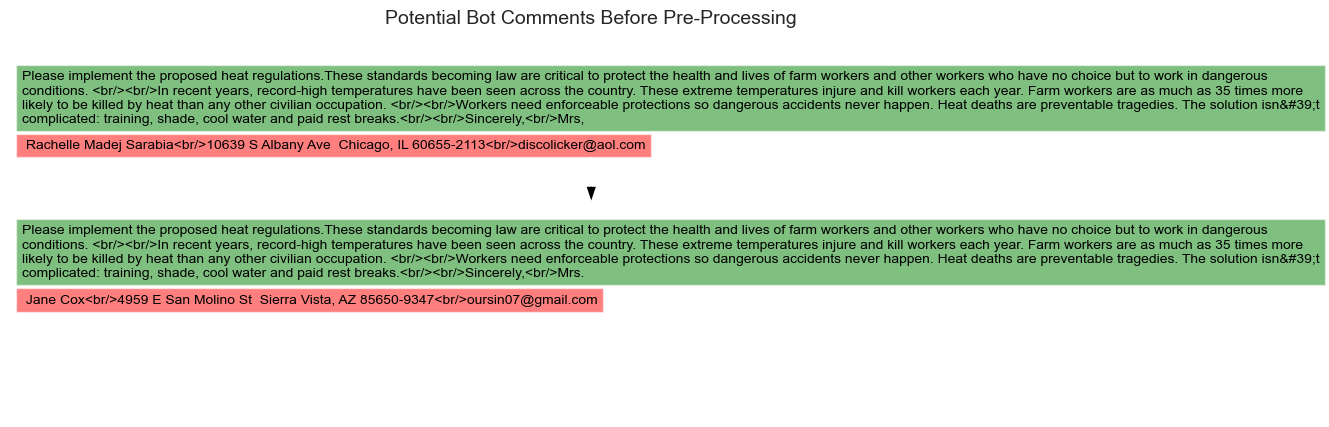

In [1669]:
import matplotlib.pyplot as plt

# Raw comment
comment_1 = df_comments['Comment'].iloc[20] # Change the index to pick a different comment
comment_2 = df_comments['Comment'].iloc[21] # Change the index to pick a different comment

# Split into two parts: highlighted and the rest
highlighted_text_1 = comment_1.split("Mrs.")[0] + "Mrs,"
remaining_text_1 = comment_1[len(highlighted_text_1):]

# Split into two parts: highlighted and the rest
highlighted_text_2 = comment_2.split("Mrs.")[0] + "Mrs."
remaining_text_2 = comment_2[len(highlighted_text_2):]

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.9, highlighted_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add the remaining text
plt.text(0.01, 0.72, remaining_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="red", alpha=0.5),wrap=True)
# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.5, highlighted_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
plt.text(0.01, 0.32, remaining_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="red", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Potential Bot Comments Before Pre-Processing", fontsize=14)
plt.show()


<b>Comments becoming duplicates after pre-preprocessing:</b>

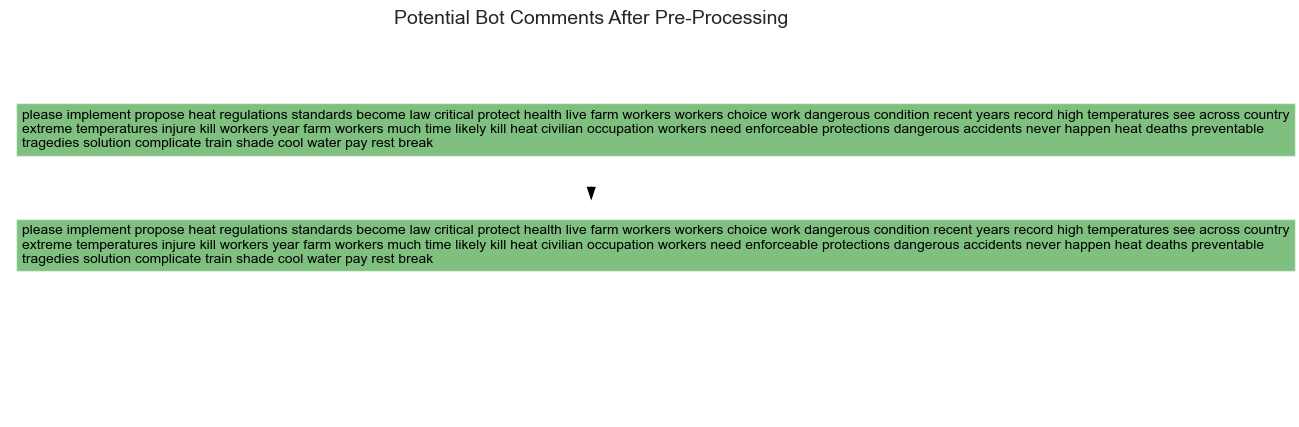

In [1671]:
# Raw comment
comment_1 = df_comments['Processed_Comment'].iloc[20]
comment_2 = df_comments['Processed_Comment'].iloc[21] 

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.8, comment_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.5, comment_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Potential Bot Comments After Pre-Processing", fontsize=14)
plt.show()

<b>Number of Duplicates after Pre-Processing:</b>

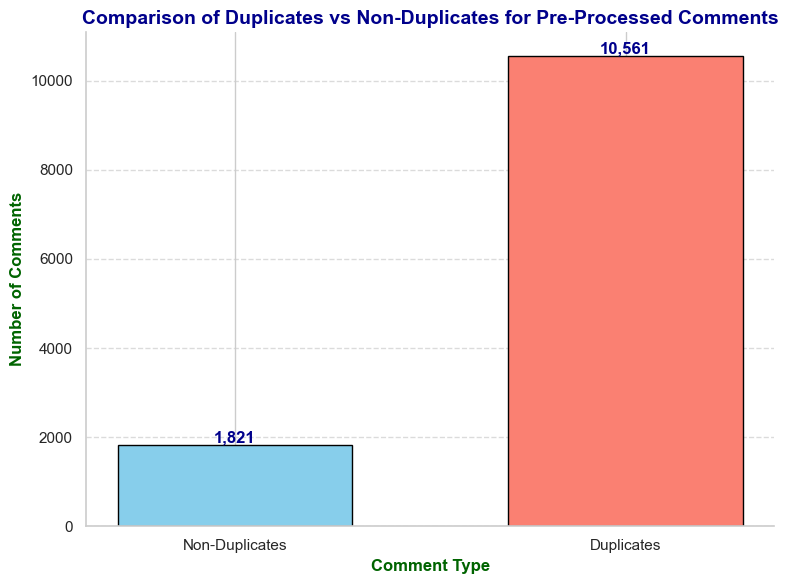

In [1672]:

# Calculate duplicates and non-duplicates
duplicates_count = df_comments["Processed_Comment"].duplicated(keep=False).sum()
non_duplicates_count = len(df_comments) - duplicates_count

# Data for the plot
labels = ['Non-Duplicates', 'Duplicates']
counts = [non_duplicates_count, duplicates_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f"{height:,}",  # Format the numbers with commas
        ha='center', va='bottom', fontsize=12, weight='bold', color='darkblue'
    )

# Style the plot
ax.set_title("Comparison of Duplicates vs Non-Duplicates for Pre-Processed Comments", fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel("Number of Comments", fontsize=12, fontweight='bold', color='darkgreen')
ax.set_xlabel("Comment Type", fontsize=12, fontweight='bold', color='darkgreen')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<b>Duplicated Comments:</b> After Processing the comments, we find that a lot of them are identical

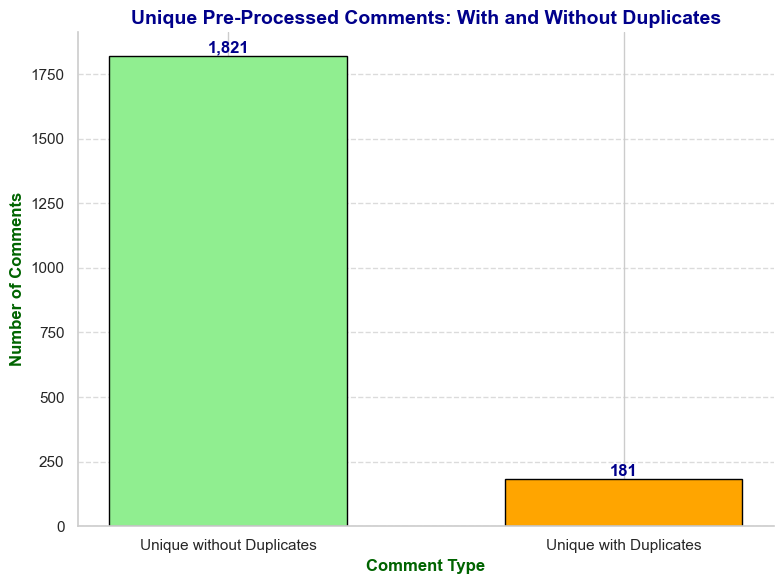

In [1673]:

# Identify unique comments and categorize them
unique_comments = df_comments["Processed_Comment"].drop_duplicates(keep='first')  # Unique comments
total_unique = len(unique_comments)

# Count unique comments with and without duplicates
has_duplicates = df_comments["Processed_Comment"].duplicated(keep=False).groupby(df_comments["Processed_Comment"]).sum() > 1
unique_with_duplicates = has_duplicates.sum()
unique_without_duplicates = total_unique - unique_with_duplicates

# Data for the plot
labels = ['Unique without Duplicates', 'Unique with Duplicates']
counts = [unique_without_duplicates, unique_with_duplicates]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=['lightgreen', 'orange'], edgecolor='black', width=0.6)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f"{height:,}",  # Format the numbers with commas
        ha='center', va='bottom', fontsize=12, weight='bold', color='darkblue'
    )

# Style the plot
ax.set_title("Unique Pre-Processed Comments: With and Without Duplicates", fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel("Number of Comments", fontsize=12, fontweight='bold', color='darkgreen')
ax.set_xlabel("Comment Type", fontsize=12, fontweight='bold', color='darkgreen')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<b>Comment Similarity:</b> Let's look at the cosine similarity and find comments with the highest cosine similarity

In [1674]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
# Step 1: Vectorize the comments using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_comments['Comment'])

# Step 2: Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Find the highest similarity score and corresponding comment for each comment
highest_similarity_scores = []
most_similar_comments = []
for i in range(len(cosine_sim)):
    # Exclude self-similarity (diagonal elements)
    cosine_sim[i, i] = 0
    max_sim_idx = cosine_sim[i].argmax()  # Index of the highest similarity score
    highest_similarity_scores.append(cosine_sim[i].max())  # Highest similarity score
    most_similar_comments.append(df_comments['Comment'][max_sim_idx])  # Corresponding comment

# Step 4: Add the highest similarity score and most similar comment as new columns
df_comments['Highest_Similarity_Score'] = highest_similarity_scores
df_comments['Most_Similar_Comment'] = most_similar_comments



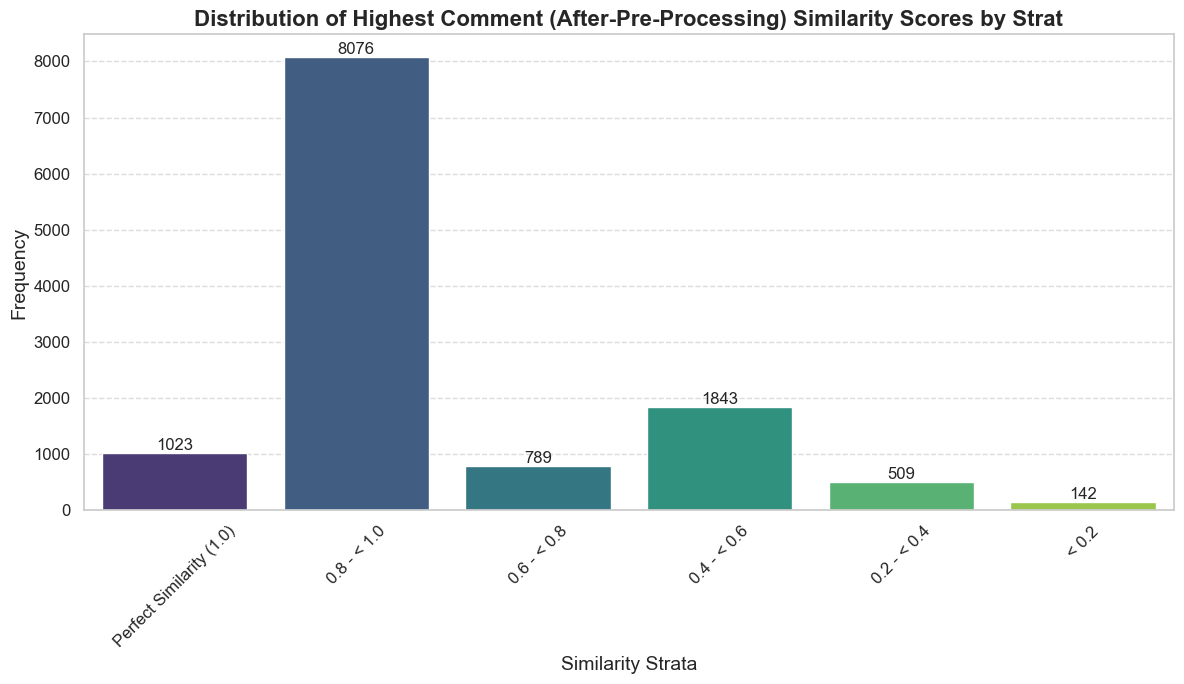

In [1675]:
# Step 1: Bin the similarity scores into strata
def stratify_score(score):
    if score == 1.0:
        return "Perfect Similarity (1.0)"
    elif score >= 0.8:
        return "0.8 - < 1.0"
    elif score >= 0.6:
        return "0.6 - < 0.8"
    elif score >= 0.4:
        return "0.4 - < 0.6"
    elif score >= 0.2:
        return "0.2 - < 0.4"
    else:
        return "< 0.2"

df_comments['Similarity_Strat'] = df_comments['Highest_Similarity_Score'].apply(stratify_score)

# Step 2: Count the frequency of each strat and ensure all strata are included
strata_order = ["Perfect Similarity (1.0)", "0.8 - < 1.0", "0.6 - < 0.8", "0.4 - < 0.6", "0.2 - < 0.4", "< 0.2"]
strat_counts = df_comments['Similarity_Strat'].value_counts().reindex(strata_order, fill_value=0).reset_index()
strat_counts.columns = ['Similarity_Strat', 'Count']

# Step 3: Plot the data
plt.figure(figsize=(12, 7))
sns.barplot(data=strat_counts, x='Similarity_Strat', y='Count', palette='viridis')
plt.title('Distribution of Highest Comment (After-Pre-Processing) Similarity Scores by Strat', fontsize=16, fontweight='bold')
plt.xlabel('Similarity Strata', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar_label(plt.gca().containers[0], fmt='%d', fontsize=12, label_type='edge')  # Add labels to bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<b>Analyzing Time Stamps Between Comments: </b> We find suspicious patterns with regards to bot activity

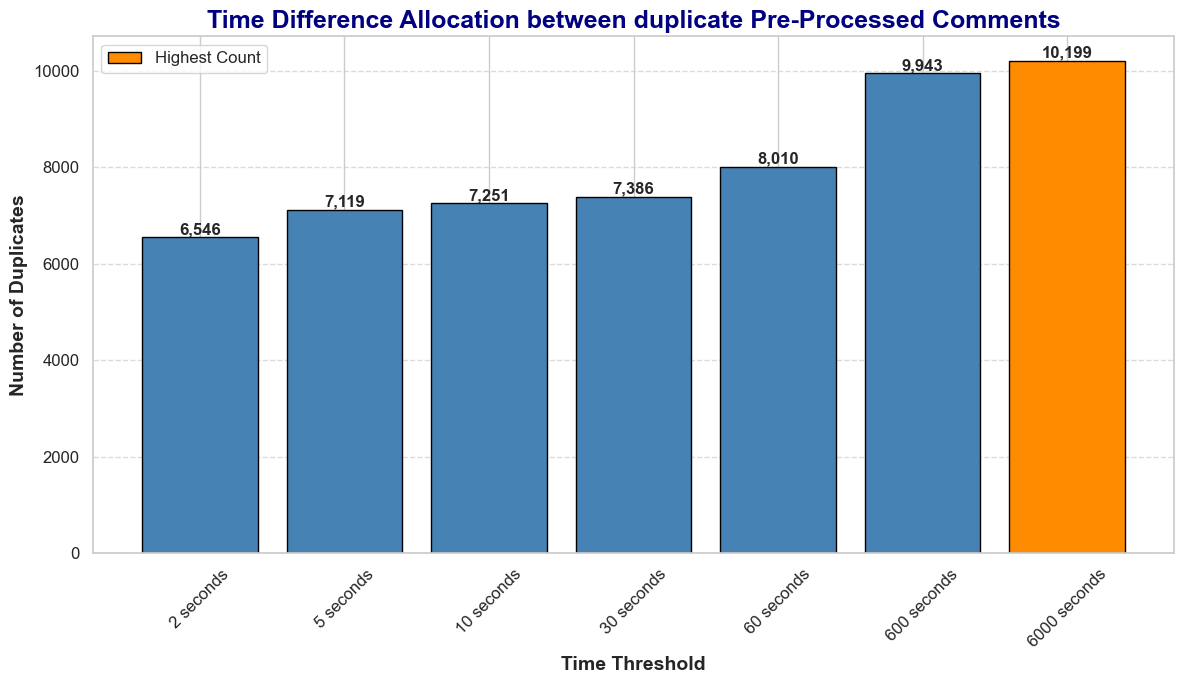

In [1676]:
from datetime import timedelta

# Ensure 'Time of Comment' is a datetime object

# Step 1: Identify Duplicates
df_comments['Is_Duplicate'] = df_comments.duplicated(subset=['Processed_Comment'], keep=False)

# Step 2: Calculate Time Difference
# Sort by 'Processed_Comment' and 'Time of Comment' for accurate time difference calculation
df_comments = df_comments.sort_values(by=['Processed_Comment', 'Time of Comment']).reset_index(drop=True)

# Create a column for the time difference between consecutive duplicates
df_comments['Time_Difference'] = df_comments.groupby('Processed_Comment')['Time of Comment'].diff()

# Step 3: Count duplicates within time thresholds
thresholds = [2, 5, 10, 30, 60, 600, 6000]  # Seconds
threshold_counts = {}

for threshold in thresholds:
    threshold_timedelta = timedelta(seconds=threshold)
    threshold_counts[f"{threshold} seconds"] = df_comments[
        (df_comments['Is_Duplicate']) & (df_comments['Time_Difference'] <= threshold_timedelta)
    ].shape[0]

# Convert the threshold counts into a DataFrame for plotting
threshold_df = pd.DataFrame({
    "Threshold": threshold_counts.keys(),
    "Duplicate_Counts": threshold_counts.values()
})

# Step 4: Enhanced Visualization
plt.figure(figsize=(12, 7))
bars = plt.bar(threshold_df['Threshold'], threshold_df['Duplicate_Counts'], color='steelblue', edgecolor='black')

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f"{yval:,}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add aesthetic touches
plt.title("Time Difference Allocation between duplicate Pre-Processed Comments", fontsize=18, fontweight='bold', color='navy')
plt.xlabel("Time Threshold", fontsize=14, fontweight='bold')
plt.ylabel("Number of Duplicates", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the bar with the maximum value for emphasis
max_value = max(threshold_df['Duplicate_Counts'])
max_bar = bars[threshold_df['Duplicate_Counts'].idxmax()]
max_bar.set_color('darkorange')
max_bar.set_edgecolor('black')

# Add a legend
plt.legend([max_bar], ["Highest Count"], loc='upper left', fontsize=12)

# Final layout adjustments
plt.tight_layout()
plt.show()

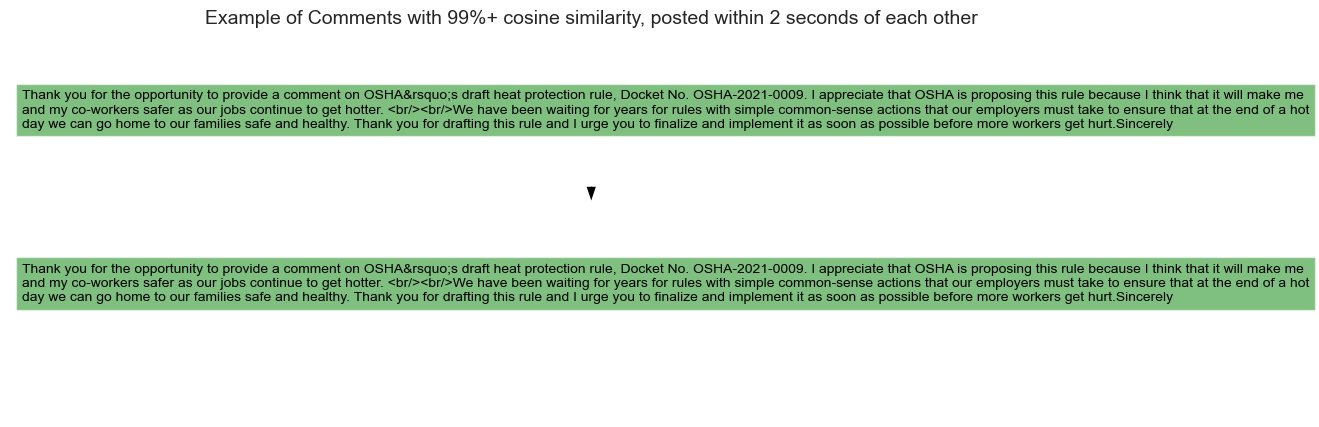

In [1677]:
# Step 2: Calculate Time Difference
# Sort by 'Processed_Comment' and 'Time of Comment' for accurate time difference calculation
df_comments_dif = df_comments.sort_values(by=['Processed_Comment', 'Time of Comment']).reset_index(drop=True)

# Create a column for the time difference between consecutive duplicates
df_comments_dif['Time_Difference'] = df_comments_dif.groupby('Processed_Comment')['Time of Comment'].diff()

# Step 3: Extract Rows with Duplicates under 2 Seconds
threshold_timedelta = timedelta(seconds=2)
duplicates_under_two_seconds = df_comments_dif[
    (df_comments_dif['Is_Duplicate']) & (df_comments_dif['Time_Difference'] <= threshold_timedelta)
]
duplicates_under_two_seconds_comment = duplicates_under_two_seconds['Comment'].iloc[0]
duplicates_under_two_seconds_comment_dup = duplicates_under_two_seconds.Most_Similar_Comment.iloc[0]
import matplotlib.pyplot as plt

# Raw comment
comment_1 = duplicates_under_two_seconds_comment # Change the index to pick a different comment
comment_2 = duplicates_under_two_seconds_comment_dup # Change the index to pick a different comment

# Split into two parts: highlighted and the rest
highlighted_text_1 = comment_1.split("Sincerely")[0] + "Sincerely"
remaining_text_1 = comment_1[len(highlighted_text_1):]

# Split into two parts: highlighted and the rest
highlighted_text_2 = comment_2.split("Sincerely")[0] + "Sincerely"
remaining_text_2 = comment_2[len(highlighted_text_2):]

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.85, highlighted_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add the remaining text
plt.text(0.01, 0.72, remaining_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="red", alpha=0.5),wrap=True)
# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.4, highlighted_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
plt.text(0.01, 0., remaining_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="red", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Example of Comments with 99%+ cosine similarity, posted within 2 seconds of each other", fontsize=14)
plt.show()


<b>We Remove Pre-Processed Duplicate Comments</b>

In [1678]:
import numpy as np
df_comments.replace(r'^\s*$', np.nan, regex=True)
df_comments = df_comments[~df_comments['Is_Duplicate'] == True].dropna(subset=['Processed_Comment']).reset_index(drop=True)

<b>Word Cloud and Term Frequency for comments:</b>

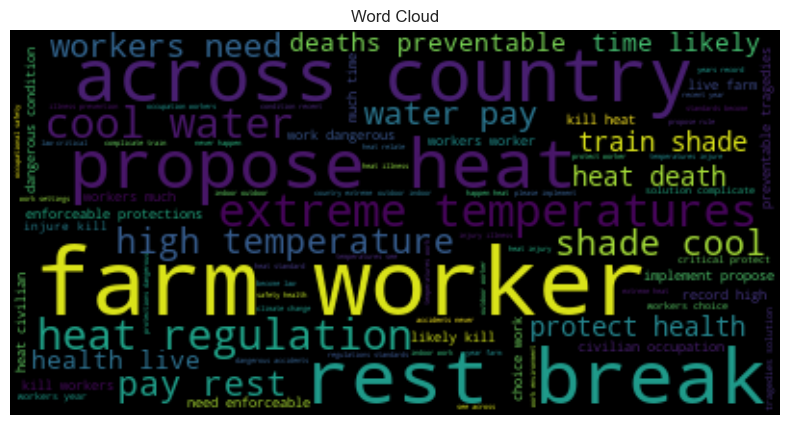

In [1679]:
from wordcloud import WordCloud
from collections import Counter

def plot_tf_and_wordcloud(df, column_name, max_font_size=50, max_words=100, background_color="black"):
    # 1. Term Frequency Calculation and Bar Chart

    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()
plot_tf_and_wordcloud(df_comments, "Processed_Comment")
    

top_words = Counter([item for sublist in df_comments['Tokens'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')
    # 2. Word Cloud Generation
top_words_df.style.background_gradient(cmap='Blues')


<b>For Documents</b>

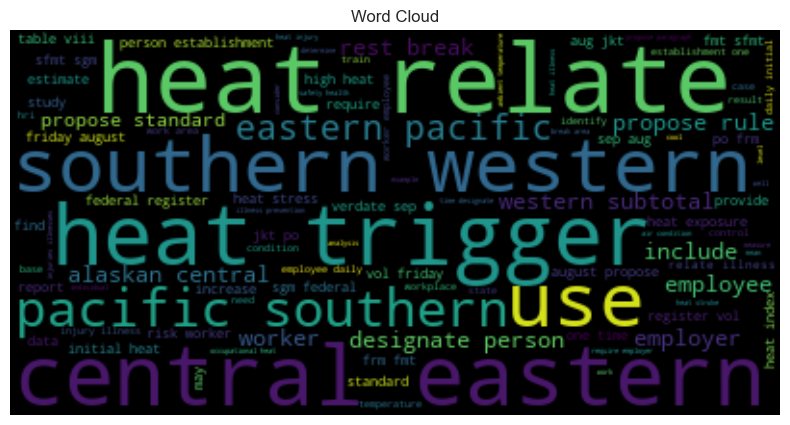

In [1680]:
plot_tf_and_wordcloud(df_docs, "Processed_Corpus")
df_docs['temp_list'] = df_docs['Processed_Corpus'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df_docs['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])


    # 2. Word Cloud Generation
top_words_df.style.background_gradient(cmap='Blues')

<b>Graph Showing the proportion per POS Tag:</b> This suggests that the majority is of the processed comments mostly contain nouns, following by a high count of adjectives, then plurial nouns

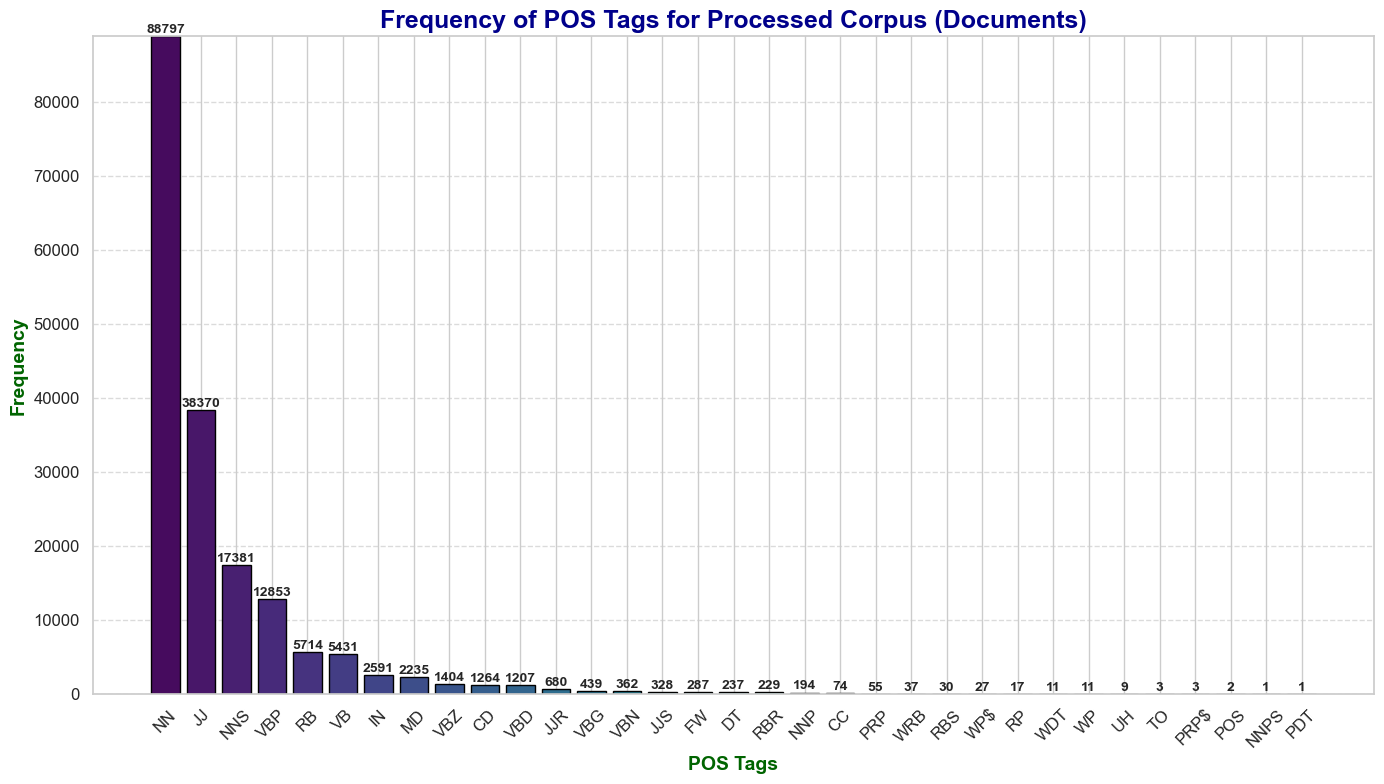

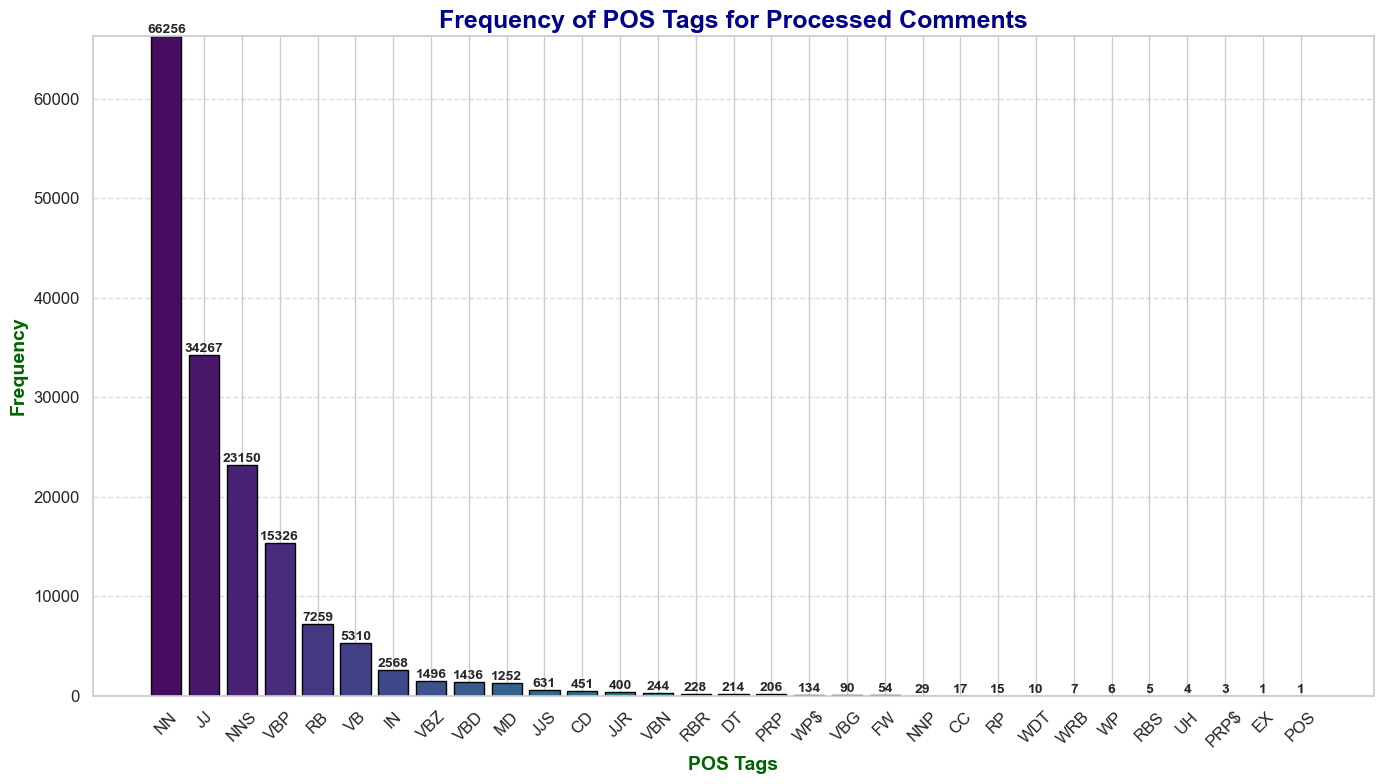

In [1681]:
import nltk
import seaborn as sns
# Assuming df is already processed and contains the 'Processed_Comments' column

# Function to perform POS tagging and generate a plot
def plot_pos_tags(df, column, title):
    # Tokenize the specified column
    df['tokens'] = df[column].apply(word_tokenize)
    
    # Flatten the list of tokenized sentences
    all_words = [word for sublist in df['tokens'] for word in sublist]
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(all_words)
    
    # Count the frequency of each POS tag
    pos_counts = Counter(tag for word, tag in pos_tags)
    
    # Sort the tags and counts by frequency in descending order
    sorted_pos_counts = sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)
    
    # Separate tags and their counts for plotting
    tags, counts = zip(*sorted_pos_counts)
    
    # Set the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", len(tags))
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(tags, counts, color=palette, edgecolor='black')
    
    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize the appearance
    plt.title(title, fontsize=18, fontweight='bold', color='darkblue')
    plt.xlabel("POS Tags", fontsize=14, fontweight='bold', color='darkgreen')
    plt.ylabel("Frequency", fontsize=14, fontweight='bold', color='darkgreen')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, max(counts) + 10)
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to df_docs and df_comments
plot_pos_tags(df_docs, 'Processed_Corpus', "Frequency of POS Tags for Processed Corpus (Documents)")
plot_pos_tags(df_comments, 'Processed_Comment', "Frequency of POS Tags for Processed Comments")


<b>Length of Processed Comments:</b> the violin graph has a long tail distribution, showing that shorter comments are more common with a concentration of 50 to 100 words.

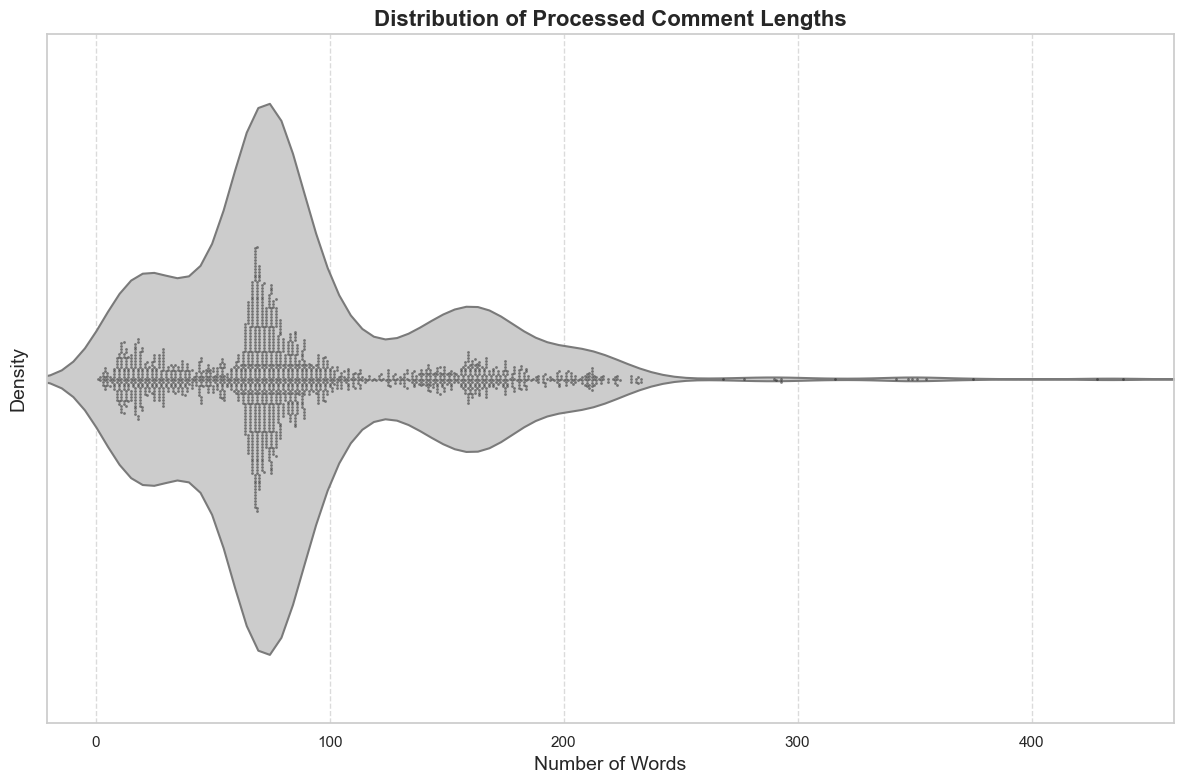

In [1682]:
# Define a function to calculate lengths and plot the distribution
def plot_comment_length_distribution(df, column, title):
    """
    Function to calculate comment lengths and create a violin plot with swarm overlay.
    
    Args:
        df (DataFrame): DataFrame containing the data.
        column (str): The column containing processed text.
        title (str): Title of the plot.
    
    Returns:
        None
    """
    # Calculate the length of each comment
    df['Comment_Length'] = df[column].apply(lambda x: len(word_tokenize(str(x))))
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Create a violin plot
    sns.violinplot(x=df['Comment_Length'], inner=None, color=".8")
    
    # Overlay a swarm plot
    sns.swarmplot(x=df['Comment_Length'], size=2, color='k', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Distribution of {title} Lengths', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Words', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to both DataFrames
plot_comment_length_distribution(df_comments, 'Processed_Comment', "Processed Comment")

<b>N-Grams:</b> 'workers', 'heat', and 'work' are the most common unigrams, indicating the prevalence of discussions surrounding workers conditions in the docket comments. Bi-grams show the prevalence of safety measures and policy considerations. Same with Tri-grams, showing the geographical implications regarding the docket.

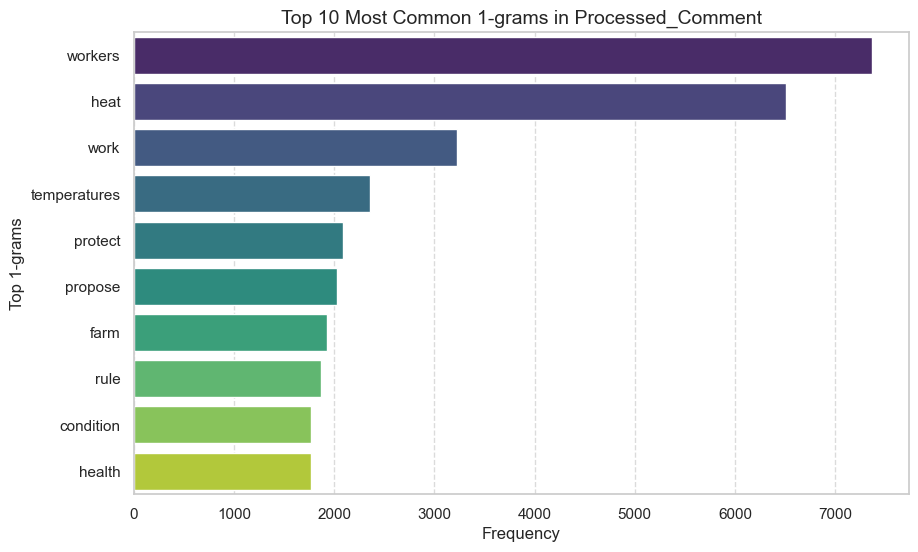

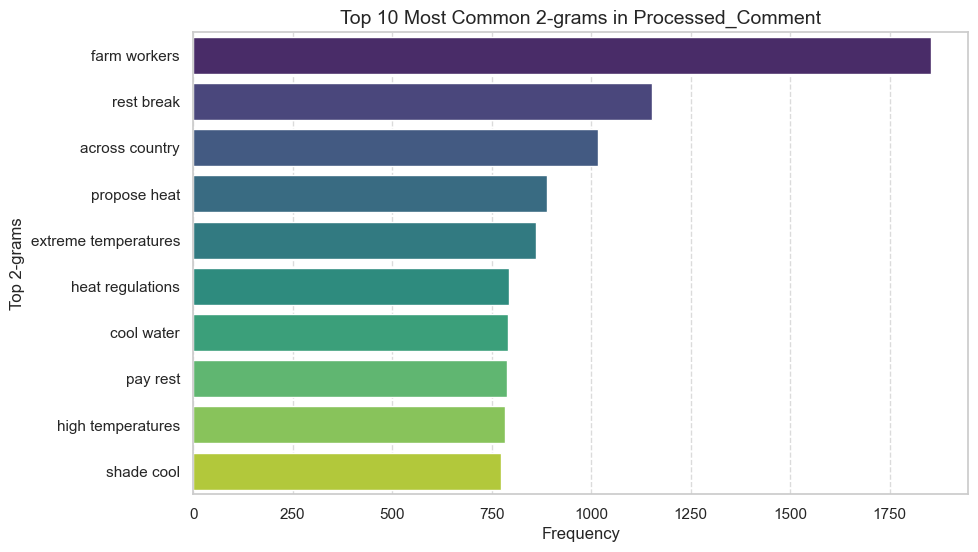

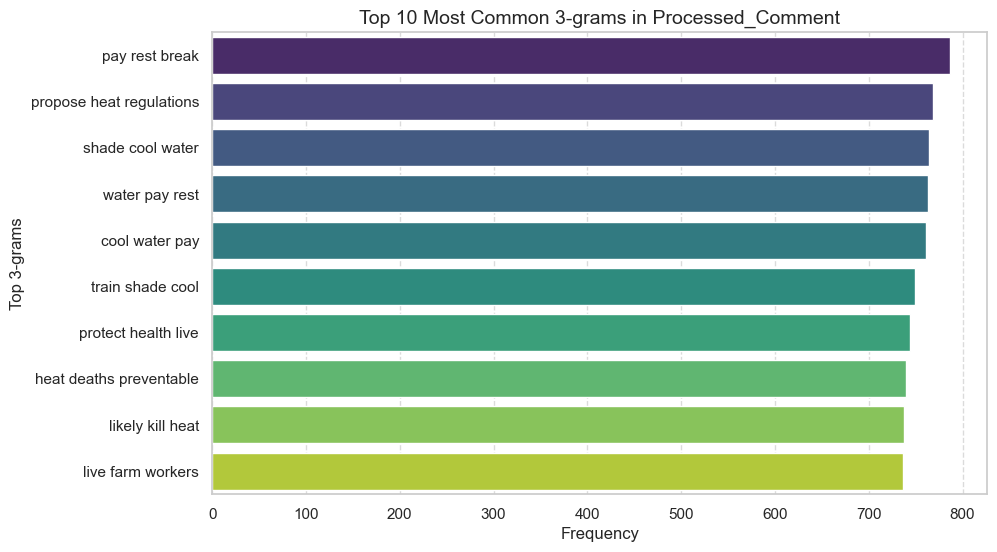

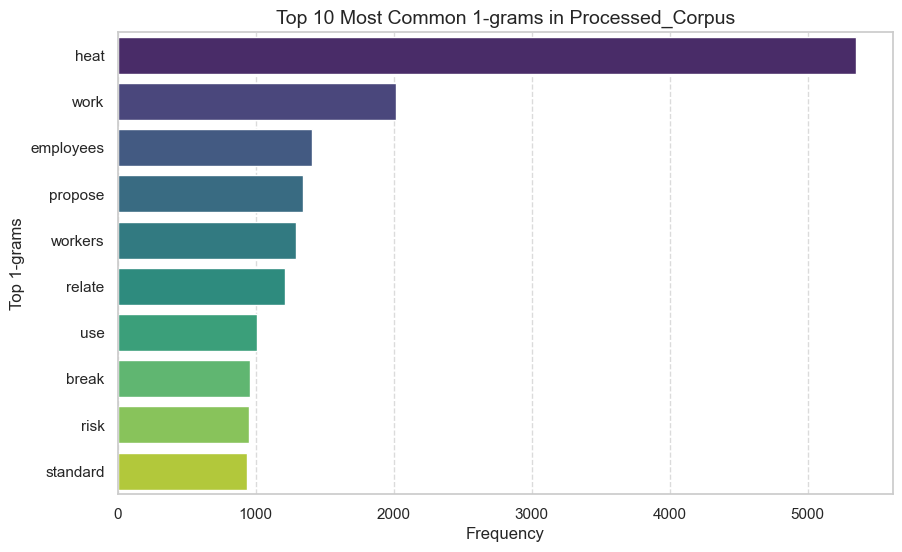

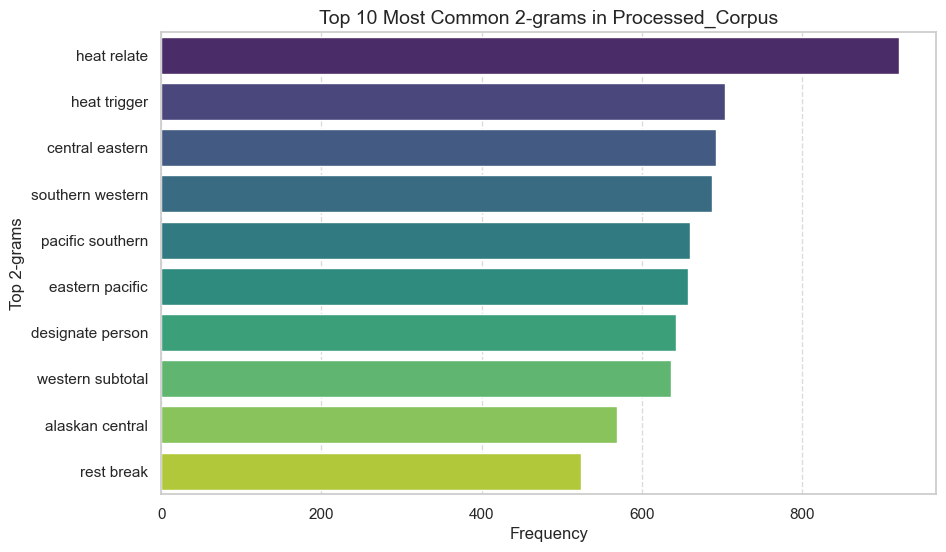

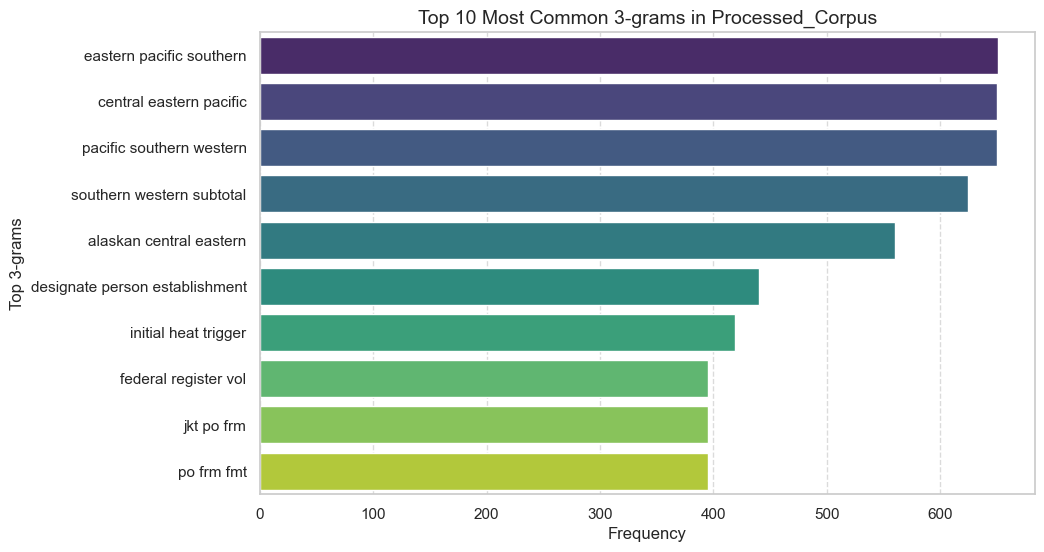

In [1683]:
from nltk.util import ngrams
# Function to generate n-grams
def generate_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

# Function to plot n-gram frequencies
def plot_ngrams(df, text_column, n, top_n=10, dataset_label=''):
    # Generate n-grams
    df[f'{n}-grams'] = df[text_column].apply(lambda x: generate_ngrams(x, n))
    
    # Flatten the list of n-grams
    all_ngrams = [ngram for sublist in df[f'{n}-grams'] for ngram in sublist]
    
    # Count the frequency of each n-gram
    ngram_freq = Counter(all_ngrams)
    
    # Get the most common n-grams
    common_ngrams = ngram_freq.most_common(top_n)
    
    # Separate the n-grams and their frequencies for plotting
    ngrams_list, frequencies = zip(*common_ngrams)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(ngrams_list), palette='viridis')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(f'Top {n}-grams', fontsize=12)
    plt.title(f'Top {top_n} Most Common {n}-grams in {dataset_label}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Plot unigrams, bigrams, and trigrams for comments
plot_ngrams(df_comments, 'Processed_Comment', 1, top_n=10, dataset_label='Processed_Comment')
plot_ngrams(df_comments, 'Processed_Comment', 2, top_n=10, dataset_label='Processed_Comment')
plot_ngrams(df_comments, 'Processed_Comment', 3, top_n=10, dataset_label='Processed_Comment')

# Plot unigrams, bigrams, and trigrams for documents
plot_ngrams(df_docs, 'Processed_Corpus', 1, top_n=10, dataset_label='Processed_Corpus')
plot_ngrams(df_docs, 'Processed_Corpus', 2, top_n=10, dataset_label='Processed_Corpus')
plot_ngrams(df_docs, 'Processed_Corpus', 3, top_n=10, dataset_label='Processed_Corpus')

# 4. Sentiment Analysis

<b>Pre-Processing for Vader</b>

In [1684]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df_comments_sentiment = df_comments.copy()
# Filter the DataFrame
df_comments_sentiment = df_comments_sentiment[df_comments_sentiment['Highest_Similarity_Score'] < 0.9]
df_comments_sentiment = df_comments_sentiment[df_comments_sentiment['Comment_Length'] > 5]

def vader_preprocessing(text):
    # Convert to lowercase
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_comments_sentiment['Vader_Processed_Comments'] =  df_comments_sentiment['Comment'].apply(vader_preprocessing)
df_comments_sentiment.loc[:,['Vader_Processed_Comments']]

Vader_Processed_Comments
0     As ab ex restaurant worker, I urge the Occupat...
1     It is absolutely necessary to implement the pr...
2     This is absolutely necessary and I am PM for a...
3     We absolutely need heat protections for the wo...
4     This is absolutely over the top. Unnecessary a...
...                                                 ...
1813  Yes please! I don&#39;t want to be cooked at m...
1814  Yes, I read the proposed regulation. There sho...
1817  Yes, yes, yes, I fully support the Occupationa...
1819  As a young man, I worked in a steel mill and I...
1820  most of my youth has roots in the Manufacturin...

[1582 rows x 1 columns]

<b>Sentiment Analysis with Vader:</b>

In [1685]:
analyzer = SentimentIntensityAnalyzer()

df_comments_sentiment['Vader_Score'] = df_comments_sentiment['Vader_Processed_Comments'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df_comments_sentiment['Sentiment'] = df_comments_sentiment['Vader_Score'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < -0 else 'neutral'))

print(df_comments_sentiment[['Vader_Processed_Comments', 'Vader_Score', 'Sentiment']].head())



                            Vader_Processed_Comments  Vader_Score Sentiment
0  As ab ex restaurant worker, I urge the Occupat...       0.6872  positive
1  It is absolutely necessary to implement the pr...      -0.9796  negative
2  This is absolutely necessary and I am PM for a...       0.0772  positive
3  We absolutely need heat protections for the wo...      -0.8996  negative
4  This is absolutely over the top. Unnecessary a...      -0.7164  negative


In [1686]:
df_test = df_comments_sentiment[['Vader_Processed_Comments', 'Vader_Score', 'Sentiment']]
df_test['Vader_Processed_Comments']

0       As ab ex restaurant worker, I urge the Occupat...
1       It is absolutely necessary to implement the pr...
2       This is absolutely necessary and I am PM for a...
3       We absolutely need heat protections for the wo...
4       This is absolutely over the top. Unnecessary a...
                              ...                        
1813    Yes please! I don&#39;t want to be cooked at m...
1814    Yes, I read the proposed regulation. There sho...
1817    Yes, yes, yes, I fully support the Occupationa...
1819    As a young man, I worked in a steel mill and I...
1820    most of my youth has roots in the Manufacturin...
Name: Vader_Processed_Comments, Length: 1582, dtype: object

<b>Sentiment Distribution:</b>

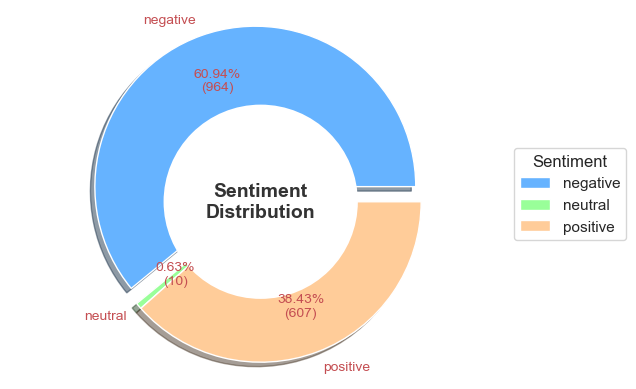

In [1687]:
import matplotlib.pyplot as plt

# Example sentiment counts
sentiment_counts = df_comments_sentiment.groupby("Sentiment").size()

# Define colors
colors = ['#66b3ff', '#99ff99', '#ffcc99']

# Create an explode tuple with the same length as sentiment_counts
explode = [0.1 if i == 0 else 0 for i in range(len(sentiment_counts))]

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()


## Time and Sentiment Analysis:

<b>Relationship between Month and Sentiment</b>

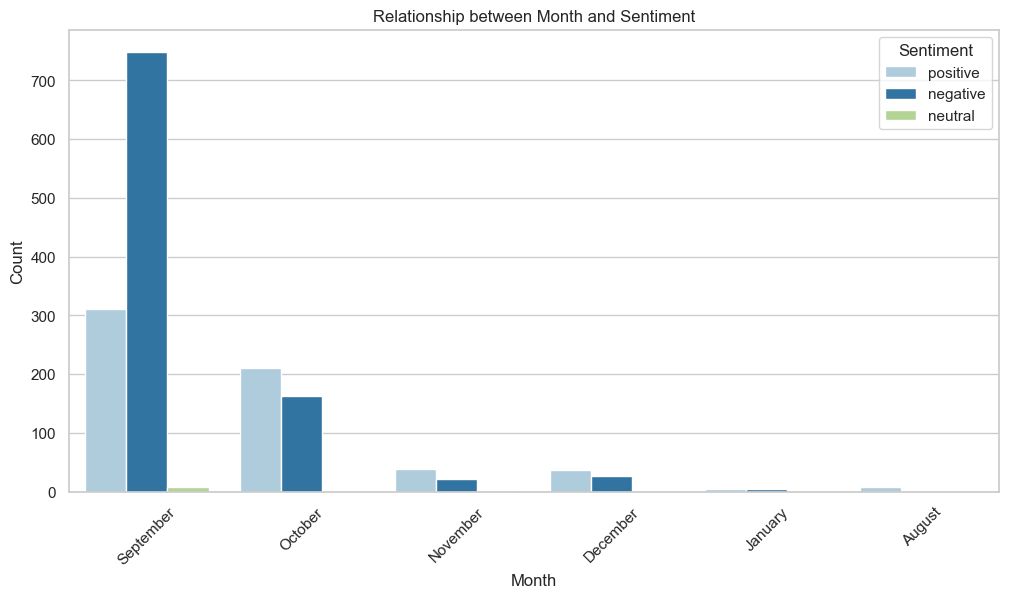

In [1688]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df_comments_sentiment, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<b>Relationship between Day of the week and sentiment</b>

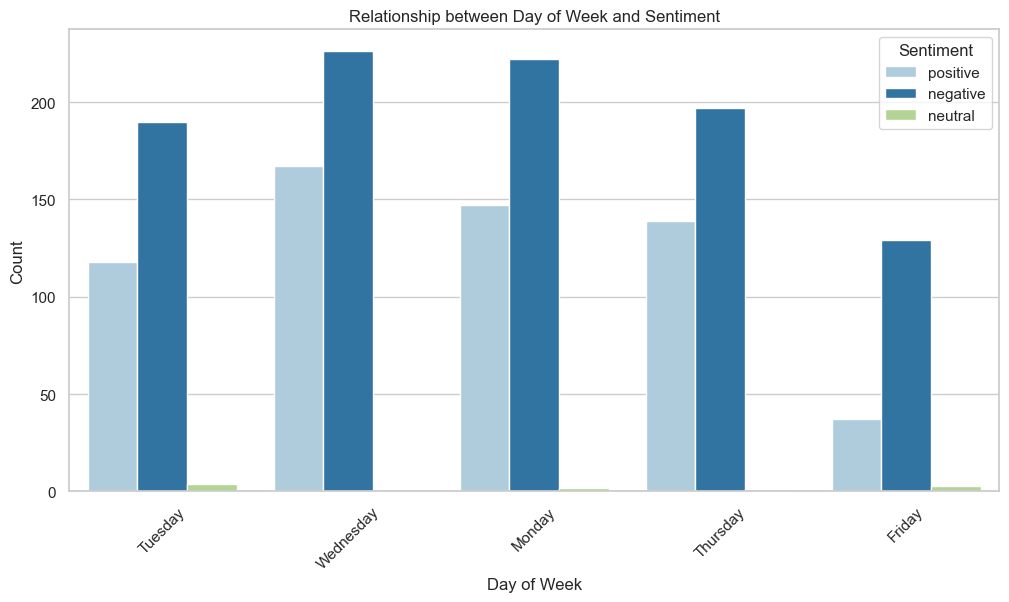

In [1689]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df_comments_sentiment, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Word Use and Sentiment:

<b>Positive Common Words</b>

In [1690]:
Positive_sent = df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'positive']
Negative_sent = df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'negative']
Neutral_sent = df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'neutral']

top = Counter([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'negative']['tokens'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(15), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

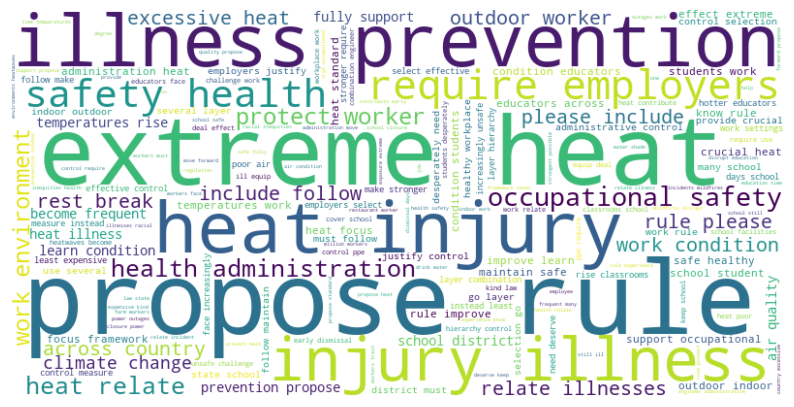

In [1691]:
words = ' '.join([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'positive']['tokens'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<b>Neutral Common Words</b>:

In [1692]:

top = Counter([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'neutral']['tokens'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

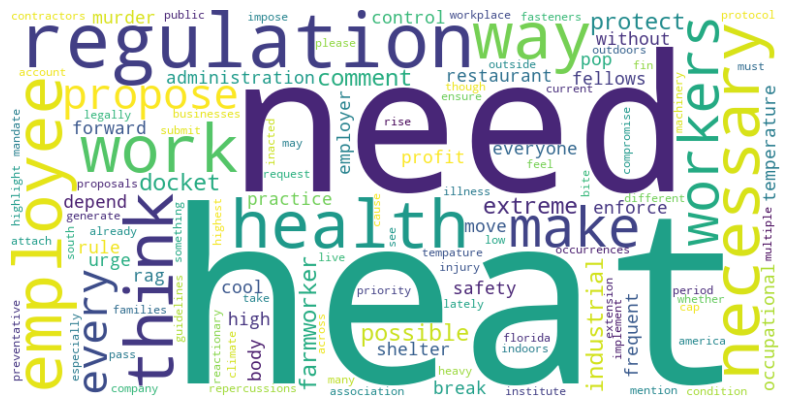

In [1693]:
words = ' '.join([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'neutral']['tokens'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<b>Negative Common Words</b>

In [1694]:
top = Counter([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'negative']['tokens'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(15), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

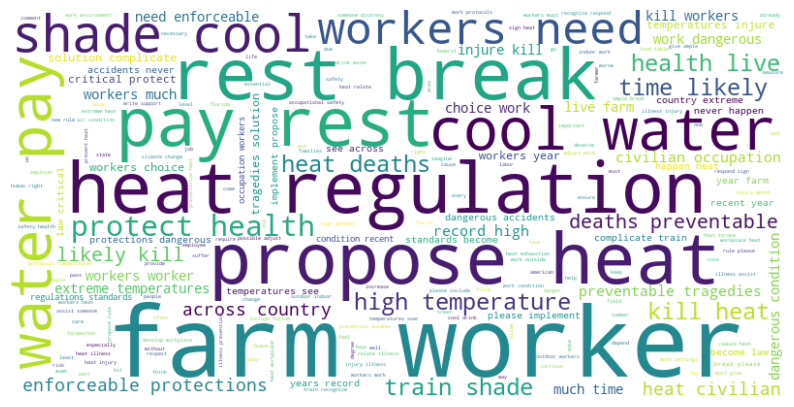

In [1695]:
words = ' '.join([item for sublist in df_comments_sentiment[df_comments_sentiment['Sentiment'] == 'negative']['tokens'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Geographical Location and Sentiment

<b>City and Sentiment Analysis:</b>

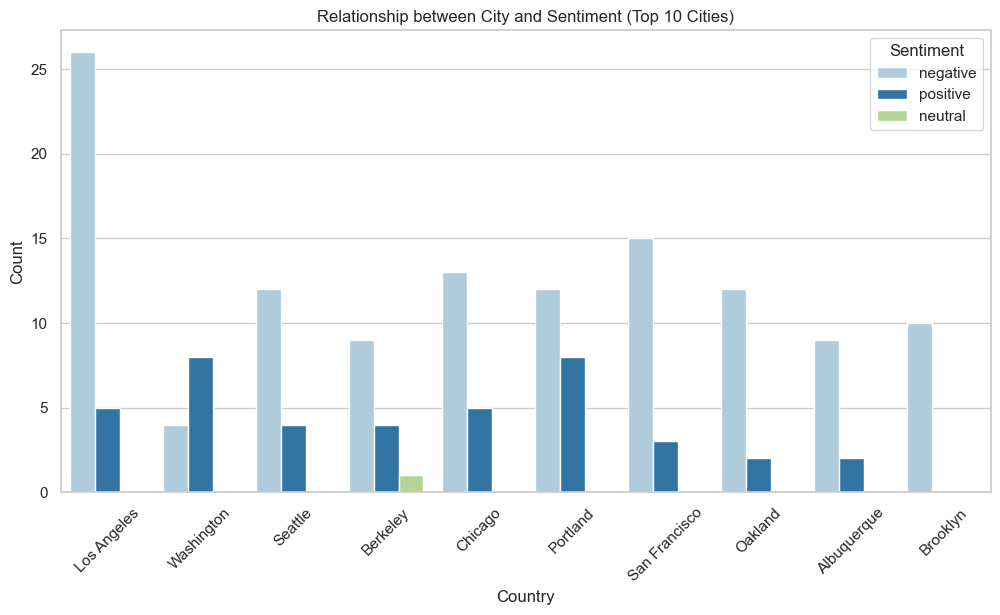

In [1696]:
plt.figure(figsize=(12, 6))

top_10_countries = df_comments_sentiment['City'].value_counts().head(10).index

df_top_10_countries = df_comments_sentiment[df_comments_sentiment['City'].isin(top_10_countries)]

sns.countplot(x='City', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between City and Sentiment (Top 10 Cities)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<b>Geographical Analysis Of Sentiment: Augmenting the Data:</b>

In [1697]:
city_coords = pd.read_csv(r'c:\Users\U355394\Desktop\Data_Augmentation_World_Cities.csv')  # Adjust the filename as needed
# Rename the column to 'City'
city_coords.rename(columns={'city': 'City'}, inplace=True)
city_coords = city_coords[city_coords['country'] == 'United States']
# Merge on 'City' column
df_merged = pd.merge(df_comments_sentiment, city_coords, on='City', how='left')
# Remove rows with missing coordinates
df_merged = df_merged.dropna(subset=['lat', 'lng'])
df_merged = df_merged.drop_duplicates(subset=['Comment_ID']).reset_index(drop=True)

<b>Creation of a Map Showing sentiment by location:</b>

In [1698]:
import folium
from branca.colormap import LinearColormap
import pandas as pd

# Create the base map
m = folium.Map(location=[df_merged["lat"].mean(), df_merged["lng"].mean()], zoom_start=6)

# Define the color scale
colormap = LinearColormap(
    colors=["red", "white", "blue"],
    vmin=-1,  # Minimum value for Vader_Score
    vmax=1,   # Maximum value for Vader_Score
    caption="Sentiment"
)

# Add the color scale to the map
colormap.add_to(m)

# Add points to the map
for _, row in df_merged.iterrows():
    # Determine color based on Vader_Score
    color = colormap(row["Vader_Score"])
    
    # Add a circle marker with tooltip for Vader_Score
    folium.CircleMarker(
        location=(row["lat"], row["lng"]),
        radius=7,  # Marker size
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=f"Vader Score: {row['Vader_Score']}"  # Tooltip to display on hover
    ).add_to(m)

# Save or display the map
m
